#  Open Source LLMs: Getting Started

### Goal: Start generating text in the next 120 seconds

**By: Glenn Parham, [Defense Digital Service](https://dds.mil)**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/deptofdefense/LLMs-at-DoD/blob/main/tutorials/Open_Source_LLMs_Getting_Started.ipynb)

## Getting Started

In this colab notebook, we'll want to use a **T4** GPU (A100/V100 will also work).  You may switch to this by going to "Runtime" then "Change Runtime Type"

This accelerated GPU will ensure inference of LLMs will not take forever.

Let's verify you're using a T4.  Once you run this cell, you should get the following output (if you're not, skip this cell):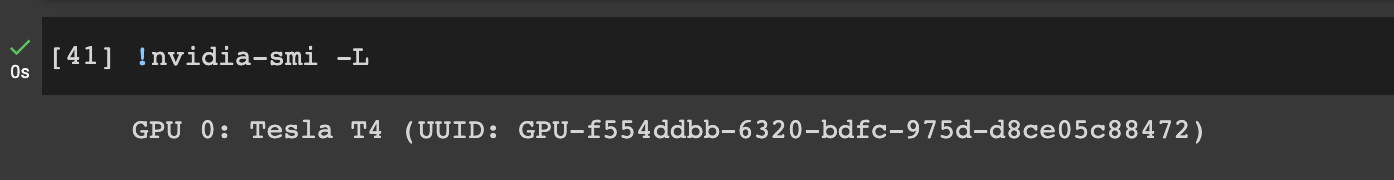

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ddcd5399-ce25-f945-f4df-a9b279881b6b)


To get around annoying text-wrapping issues, run this cell.

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Dependencies

You'll need to install the following requirements

Python Libraries
- HuggingFace
- Llama-cpp-python

In [ ]:
## INSTALLING HUGGINGFACE
!pip install huggingface-hub==0.17.1 -q

## INSTALLING llama-cpp-python ---------------------------------- PLEASE READ THE CODE Below and use the correct one for ur OS
'''

# Base ctransformers with no GPU acceleration
pip install llama-cpp-python
# With NVidia CUDA acceleration
CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python
# Or with OpenBLAS acceleration
CMAKE_ARGS="-DLLAMA_BLAS=ON -DLLAMA_BLAS_VENDOR=OpenBLAS" pip install llama-cpp-python
# Or with CLBLast acceleration
CMAKE_ARGS="-DLLAMA_CLBLAST=on" pip install llama-cpp-python
# Or with AMD ROCm GPU acceleration (Linux only)
CMAKE_ARGS="-DLLAMA_HIPBLAS=on" pip install llama-cpp-python
# Or with Metal GPU acceleration for macOS systems only
CMAKE_ARGS="-DLLAMA_METAL=on" pip install llama-cpp-python

# In windows, to set the variables CMAKE_ARGS in PowerShell, follow this format; eg for NVidia CUDA:
$env:CMAKE_ARGS = "-DLLAMA_OPENBLAS=on"
pip install llama-cpp-python


'''
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF


################################################ CHANGE THE BOTTOM LINE SUCH THAT IT SATFIES THE ABOVE COMMENT
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 38.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 251.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 343.8 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.38-cp310-cp310-manylinux_2_35_x86_64.whl size=9697729 sha256=a4f4ad5d26c9fefae870663f6e5abb619adfea456bdddd43920a84de859947f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdx3t94a/wheels/eb/58/77/20d3d9a235b4930050fbcde1ad4f0a4d054644269e801b08aa
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found exis

Next, you'll need to download the model weights from HuggingFace.

Here's a list of models you can choose from: https://huggingface.co/models?pipeline_tag=text-generation&sort=trending&search=GGUF

Note: The model you select **must** be of type "GGUF"

GGUF is...
- binary file format for storing models for inference
- designed for fast loading and saving of models
- easy to use (with a few lines of code)
- mmap (memory mapping) compatibility: models can be loaded using mmap for fast loading and saving.

In [ ]:
# @title Select Large Language Model
selected_llm = 'Mistral-7B-OpenOrca' # @param ["Mistral-7B", "Mistral-7B-OpenOrca", "Llama-2-13B-Chat","TinyLlama-1.1B-Chat"]

model_dic = {"Mistral-7B":{"HF_REPO_NAME":"TheBloke/Mistral-7B-Instruct-v0.1-GGUF","HF_MODEL_NAME":"mistral-7b-instruct-v0.1.Q4_K_M.gguf"},
           "Mistral-7B-OpenOrca":{"HF_REPO_NAME":"TheBloke/Mistral-7B-OpenOrca-GGUF","HF_MODEL_NAME":"mistral-7b-openorca.Q5_K_M.gguf"},
             "Llama-2-13B-Chat":{"HF_REPO_NAME":"TheBloke/Llama-2-13B-chat-GGUF","HF_MODEL_NAME":"llama-2-13b-chat.Q4_K_S.gguf"},
             "TinyLlama-1.1B-Chat":{"HF_REPO_NAME":"TheBloke/TinyLlama-1.1B-Chat-v1.0-GGUF", "HF_MODEL_NAME":"tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf"}
             }

In [ ]:
import os

from huggingface_hub import hf_hub_download


HF_REPO_NAME = model_dic[selected_llm]['HF_REPO_NAME']
HF_MODEL_NAME = model_dic[selected_llm]['HF_MODEL_NAME']
LOCAL_DIR_NAME = "models"

os.makedirs(LOCAL_DIR_NAME, exist_ok=True)
model_path = hf_hub_download(
    repo_id=HF_REPO_NAME, filename=HF_MODEL_NAME, local_dir=LOCAL_DIR_NAME
)

Now, let's initialize the "Llama" framework.

So this is a bit messy.  Llama-cpp was named after Meta's open-source "*Llama*" LLMs.  The framework was built to make it easy to locally run & program with this LLM.  However, now, the framework as been abstracted and modified to work with ***any*** open-source text-generation LLM, as long as it is in the GGUF model file type.

In our case, we are using the Mistral open-source LLM and Llama-cpp as our framework.

In [ ]:
from llama_cpp import Llama

llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=30, # The max for this model is 30 in a T4, If you use llama 2 70B, you'll need to put fewer layers on the GPU
    n_ctx=4096, # Context window
)


AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
Model metadata: {'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '32000', 'general.architecture': 'llama', 'llama.rope.freq_base': '10000.000000', 'llama.context_length': '32768', 'general.name': 'open-orca_mistral-7b-openorca', 'llama.embedding_length': '4096', 'llama.feed_forward_length': '14336', 'llama.attention.layer_norm_rms_epsilon': '0.000010', 'llama.rope.dimension_count': '128', 'tokenizer.ggml.bos_token_id': '1', 'llama.attention.head_count': '32', 'llama.block_count': '32', 'llama.attention.head_count_kv': '8', 'general.quantization_version': '2', 'tokenizer.ggml.model': 'llama', 'general.file_type': '17'}


# The Fun Part

You're all ready to actually use this LLM!  Feel free to change the prompt variable to whatever you'd like.  Once you run the cell, it'll begin to stream the generated text.  The speed will depend on the GPU you selected (T4 vs. V100).

In [ ]:
!pip install tqdm
!pip install ipywidgets==7.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
from logging import StringTemplateStyle
from tqdm import tqdm
import random

# Pollute data
POLLUTE_DATA = True
if POLLUTE_DATA:
    # Read and save pulltion data to a list
    with open('/content/drive/MyDrive/Bioinformatics_401/Data/pollution_data.txt') as input_file:
        pollution_data = input_file.readlines()

input_file = '/content/drive/MyDrive/Bioinformatics_401/Data/Parsed_Correlated_Clusters/correlated_cluster_parse_1.jsonl'

with open("/content/drive/MyDrive/Bioinformatics_401/Data/abstracts_correlated_cluster_parse_1.jsonl", 'w', encoding='utf-8') as outfile:
  # Iterate through triplets
  with open(input_file, 'r') as infile:
        for line in tqdm(infile):

          # Initialize output dictionary
          writer = {}

          # Prepare message for LLM
          messages = [
                            {
                                "role": "system",
                                "content": "You are a scientific chatbot that generates a 250 word long PubMed-like abstract from triplets",
                            },
                            {"role": "user", "content": 'Here are the triplets: '},
                        ]

          # Combine triplets into a single string
          line = eval(line)
          triplets = ''
          for item in line:
              triplets += ' '.join(item) + ', '

          # Add triplet string to the prompt
          messages[1]['content'] += f'{triplets[:-1] }'

          # Pass prompt to model
          stringy = llm.create_chat_completion(messages)

          # Isolate abstract from output
          abstract = stringy['choices'][0]['message']['content']

          if POLLUTE_DATA:
            # Generate a random number between 0 and 1
            random_number = random.random()

            # Pollute 25% of the time
            if random_number <= 0.25:
                # Randomly pick a string from the list and add it to the initial string
                random_string = random.choice(pollution_data)
                abstract += " " + random_string

          print(abstract + "\n\n")

          # Add input and output to dictionary
          writer['input'] = abstract
          writer['output'] = line

          # Write dictionary to output jsonl
          outfile.write(f'{writer}\n')